In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import calendar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.fftpack import fft
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.seasonal import STL

In [3]:
RANDOM_STATE = 23

In [4]:
def preprocess_time_series(
    df: pd.DataFrame,
    target: str,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True,
    window_size: int = 10
):
    """
    Предобрабатывает временной ряд для столбца 'target' в DataFrame, изменяя только этот столбец,
    с возможностью восстановления исходных значений.

    Параметры:
    ----------
    df : pd.DataFrame
        Исходный DataFrame.
    target : str
        Название столбца, для которого выполняются преобразования.
    do_scale : bool, по умолчанию True
        Выполнять ли масштабирование.
    do_diff : bool, по умолчанию True
        Выполнять ли дифференцирование.
    do_yeo_johnson : bool, по умолчанию True
        Выполнять ли преобразование Yeo-Johnson.
    do_window_normalizing : bool, по умолчанию True
        Выполнять ли оконную нормализацию.
    window_size : int, по умолчанию 10
        Размер окна для оконной нормализации.

    Возвращает:
    -----------
    df_transformed : pd.DataFrame
        Преобразованный DataFrame с только изменённым столбцом 'target'.
    transformers : dict
        Словарь с объектами трансформеров для восстановления значений.
    """
    df_transformed = df.copy()

    ts = df_transformed[target].copy()
    transformers = {}

    # Масштабирование.
    if do_scale:
        values = ts.values.reshape(-1, 1)

        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(values)

        ts = pd.Series(
            data=scaled_values.flatten(),
            index=ts.index,
            name=ts.name
        )

        transformers['scaler'] = scaler

    # Дифференцирование.
    if do_diff:
        ts_diff = ts.copy()
        ts = ts.diff()
        ts.dropna(inplace=True)

        transformers['last_value'] = ts_diff.iloc[0]

    # Преобразование Yeo-Johnson.
    if do_yeo_johnson:
        pt = PowerTransformer(method='yeo-johnson', standardize=False)

        # Отбрасываем NaN-значения и применяем трансформацию.
        transformed_values = np.full_like(ts.values, np.nan, dtype=float)
        non_nan_mask = ~np.isnan(ts.values)
        non_nan_values = ts.values[non_nan_mask].reshape(-1, 1)

        if len(non_nan_values) > 0:
            transformed_values[non_nan_mask] = pt.fit_transform(non_nan_values).flatten()

        ts = pd.Series(transformed_values, index=ts.index, name=ts.name)

        transformers['yeo_johnson'] = pt

    # Оконная нормализация.
    if do_window_normalizing:
        rolled_mean = np.convolve(ts, np.ones(window_size) / window_size, mode='valid')
        rolled_std = np.std(np.lib.stride_tricks.sliding_window_view(ts, window_size), axis=1)

        transformers['rolled_mean'] = rolled_mean
        transformers['rolled_std'] = rolled_std

        eps = 1e-9
        ts = (ts[window_size - 1:] - rolled_mean) / (rolled_std + eps)

    df_transformed[target] = ts
    df_transformed.dropna(inplace=True)

    return df_transformed, transformers



def inverse_preprocess_time_series(
    ts_transformed: np.array,
    transformers: dict,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True
) -> np.array:
    """
    Восстанавливает исходный временной ряд из преобразованного np.array,
    используя сохранённые параметры трансформаций, выполненных в функции preprocess_time_series.

    Параметры:
    -----------
    ts_transformed : np.array
        Преобразованный временной ряд.
    transformers : dict
        Словарь с сохранёнными объектами и параметрами трансформаций.
    do_scale : bool, по умолчанию True
        Выполнять ли масштабирование.
    do_diff : bool, по умолчанию True
        Выполнять ли дифференцирование.
    do_yeo_johnson : bool, по умолчанию True
        Выполнять ли преобразование Yeo-Johnson.
    do_window_normalizing : bool, по умолчанию True
        Выполнять ли оконную нормализацию.

    Возвращает:
    -----------
    np.array
        Восстановленный временной ряд в исходных единицах измерения.
    """
    ts = ts_transformed.copy()

    # Обратная оконная нормализация
    if do_window_normalizing:
        eps = 1e-9

        rolled_mean = transformers.get('rolled_mean')
        rolled_std = transformers.get('rolled_std')

        if rolled_mean is None or rolled_std is None:
            raise ValueError(
                "Нет сохранённых параметров оконной нормализации: 'rolled_mean' или 'rolled_std'."
            )

    # Обратное преобразование Yeo-Johnson
    if do_yeo_johnson and 'yeo_johnson' in transformers:
        pt = transformers['yeo_johnson']
        ts = pt.inverse_transform(ts.reshape(-1, 1)).flatten()

    # Обратное дифференцирование
    if do_diff and 'last_value' in transformers:
        ts = np.cumsum(ts) + transformers['last_value']

    # Обратное масштабирование
    if do_scale and 'scaler' in transformers:
        scaler = transformers['scaler']
        ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()

    return ts


def extract_time_series_features(
    df: pd.Series,
    lags=[1, 2, 3, 4, 5],
    rolling_windows=[7, 30],
    fourier_periods=[7, 30],
    horizon=1
):
    """
    Функция для автоматического извлечения признаков из временного ряда.

    Аргументы:
      df : pandas.Series или pandas.DataFrame
          Временной ряд с индексом типа datetime.
      lags : list, по умолчанию [1, 2, 3, 4, 5]
          Лаговые признаки.
      rolling_windows : list, по умолчанию [3, 5, 7, 9]
          Скользящие статистики.
      fourier_periods : list, по умолчанию [7, 30]
          Периоды для Фурье-признаков.
      horizon : int, по умолчанию 1
          Горизонт предсказания.

    Возвращает:
      DataFrame с извлеченными признаками.
    """
    if isinstance(df, pd.Series):
        df = df.to_frame(name='value')
    else:
        df = df.copy()

        if 'value' not in df.columns:
            df = df.iloc[:, [0]]
            df.columns = ['value']

    df = df.sort_index()

    # Календарные признаки.
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Лаговые признаки.
    for lag in lags:
        df[f'lag_{lag}'] = df['value'].shift(lag)

    # Разностные признаки.
    for lag in lags:
        df[f'diff_{lag}'] = df['value'] - df['value'].shift(lag)

    # Скользящие статистики.
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df['value'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['value'].rolling(window=window).std()
        df[f'rolling_min_{window}'] = df['value'].rolling(window=window).min()
        df[f'rolling_max_{window}'] = df['value'].rolling(window=window).max()

    # Признаки Фурье.
    t = np.arange(len(df))

    for period in fourier_periods:
        df[f'sin_{period}'] = np.sin(2 * np.pi * t / period)
        df[f'cos_{period}'] = np.cos(2 * np.pi * t / period)

    # Анализ Фурье.
    ts_filled = df['value'].ffill().values
    fft_values = fft(ts_filled)
    fft_power = np.abs(fft_values)**2
    dominant_idx = np.argmax(fft_power[1:]) + 1
    dominant_frequency = dominant_idx / len(df)
    df['dominant_frequency'] = dominant_frequency

    # Групповые статистики.
    df['weekday_mean'] = df.groupby(df.index.dayofweek)['value'].transform('mean')
    df['weekday_std'] = df.groupby(df.index.dayofweek)['value'].transform('std')
    df['weekday_min'] = df.groupby(df.index.dayofweek)['value'].transform('min')
    df['weekday_max'] = df.groupby(df.index.dayofweek)['value'].transform('max')

    for window in rolling_windows:
      df[f'rolling_median_{window}'] = df['value'].rolling(window=window).median()
      df[f'rolling_q25_{window}'] = df['value'].rolling(window=window).quantile(0.25)
      df[f'rolling_q75_{window}'] = df['value'].rolling(window=window).quantile(0.75)

    # Признаки на основе статистических моделей.
    stl = STL(df['value'].ffill(), seasonal=7)
    res = stl.fit()

    df['stl_trend'] = res.trend
    df['stl_seasonal'] = res.seasonal
    df['stl_residual'] = res.resid

    # Целевая переменная.
    df['target'] = df['value'].shift(-horizon)
    df.dropna(inplace=True)

    return df


def split_time_series(df, train_size=0.7, val_size=0.2, test_size=0.1):
    """
    Разбивает отсортированный временной ряд на обучающую, валидационную и тестовую выборки.

    Parameters:
      df: pd.DataFrame
        Временной ряд.
      train_size: float
        Пропорция обучающей выборки.
      val_size: float
        Пропорция валидационной выборки.
      test_size: float
        Пропорция тестовой выборки.

    Returns:
      X_train, X_val, X_test, y_train, y_val, y_test: pd.DataFrame
        Разделённые данные.
    """
    # Вычисление индексов для разбиения.
    n = len(df)

    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)

    # Разбиение данных на обучающую, валидационную и тестовую выборки.
    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    # Разделение на X и y.
    X_train, y_train = train_data.drop(columns='target'), train_data['target']
    X_val, y_val = val_data.drop(columns='target'), val_data['target']
    X_test, y_test = test_data.drop(columns='target'), test_data['target']

    return X_train, X_val, X_test, y_train, y_val, y_test


def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    model = XGBRegressor(
        **params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        verbosity=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    }

    model = CatBoostRegressor(
        **params,
        random_state=RANDOM_STATE,
        thread_count=-1,
        verbose=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    model = LGBMRegressor(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    model = RandomForestRegressor(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_ab(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
    }

    model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3),
        **params,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = DecisionTreeRegressor(
        **params,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)

In [24]:
# class TimeSeriesPipeline:
#     def __init__(self, model_name="xgb", do_scale=True, do_diff=True, do_yeo_johnson=True, do_window_normalizing=True, window_size=10, n_trials=25):
#         self.model_name = model_name
#         self.do_scale = do_scale
#         self.do_diff = do_diff
#         self.do_yeo_johnson = do_yeo_johnson
#         self.do_window_normalizing = do_window_normalizing
#         self.window_size = window_size
#         self.n_trials = n_trials
#         self.transformers = {}
#         self.model = None
#         self.best_params = {}

#     def _get_model(self, trial):
#         params = {}

#         if self.model_name == "xgb":
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#                 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
#                 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
#             }
#             return XGBRegressor(**params, objective="reg:squarederror", random_state=RANDOM_STATE, verbosity=0)

#         elif self.model_name == "catboost":
#             params = {
#                 'iterations': trial.suggest_int('iterations', 100, 1000),
#                 'depth': trial.suggest_int('depth', 3, 10),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#                 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
#                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                 'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0)
#             }
#             return CatBoostRegressor(**params, random_state=RANDOM_STATE, verbose=0, thread_count=-1)

#         elif self.model_name == "lgbm":
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#                 'num_leaves': trial.suggest_int('num_leaves', 31, 255),
#                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#                 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
#                 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
#             }
#             return LGBMRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)

#         elif self.model_name == "rf":
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#                 'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#                 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#                 'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
#             }
#             return RandomForestRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)

#         elif self.model_name == "ada":
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
#             }
#             return AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), **params, random_state=RANDOM_STATE)

#         elif self.model_name == "dt":
#             params = {
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#                 'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#                 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#             }
#             return DecisionTreeRegressor(**params, random_state=RANDOM_STATE)

#         return XGBRegressor(random_state=42)

#     def preprocess(self, df: pd.DataFrame, is_fit: bool = True):
#         df_transformed = df.copy()
#         ts = df_transformed.copy()
#         if self.do_scale:
#             scaler = StandardScaler()
#             if is_fit:
#                 ts = pd.Series(scaler.fit_transform(ts.values.reshape(-1, 1)).flatten(), index=ts.index, name=ts.name)
#                 self.transformers["scaler"] = scaler
#             else:
#                 ts = pd.Series(self.transformers["scaler"].transform(ts.values.reshape(-1, 1)).flatten(), index=ts.index, name=ts.name)


#         if self.do_diff:
#             ts_diff = ts.copy()
#             ts = ts.diff().dropna()
#             self.transformers["last_value"] = ts_diff.iloc[0]

#         if self.do_yeo_johnson:
#             pt = PowerTransformer(method="yeo-johnson", standardize=False)
#             valid_mask = ~np.isnan(ts.values)
#             if valid_mask.sum() > 0:
#                 transformed_values = np.full_like(ts.values, np.nan, dtype=float)
#                 if is_fit:
#                     transformed_values[valid_mask] = pt.fit_transform(ts.values[valid_mask].reshape(-1, 1)).flatten()
#                     self.transformers["yeo_johnson"] = pt
#                 else:
#                     transformed_values[valid_mask] = self.transformers["yeo_johnson"].transform(ts.values[valid_mask].reshape(-1, 1)).flatten()
#                 ts = pd.Series(transformed_values, index=ts.index, name=ts.name)

#         if self.do_window_normalizing:
#             rolled_mean = np.convolve(ts, np.ones(self.window_size) / self.window_size, mode="valid")
#             rolled_std = np.std(np.lib.stride_tricks.sliding_window_view(ts, self.window_size), axis=1)
#             self.transformers["rolled_mean"] = rolled_mean
#             self.transformers["rolled_std"] = rolled_std

#             eps = 1e-9
#             ts = (ts[self.window_size - 1:] - rolled_mean) / (rolled_std + eps)

#         df_transformed['target'] = ts
#         df_transformed.dropna(inplace=True)

#         return df_transformed

#     def inverse_preprocess(self, ts_transformed: np.array):
#         ts = ts_transformed.copy()

#         # Обратная оконная нормализация
#         if self.do_window_normalizing:
#             eps = 1e-9
#             rolled_mean = self.transformers.get('rolled_mean')
#             rolled_std = self.transformers.get('rolled_std')

#             if rolled_mean is None or rolled_std is None:
#                 raise ValueError(
#                     "Нет сохранённых параметров оконной нормализации: 'rolled_mean' или 'rolled_std'."
#                 )

#         if self.do_yeo_johnson and "yeo_johnson" in self.transformers:
#             ts = self.transformers["yeo_johnson"].inverse_transform(ts.reshape(-1, 1)).flatten()

#         if self.do_diff and "last_value" in self.transformers:
#             ts = np.cumsum(ts) + self.transformers["last_value"]

#         if self.do_scale and "scaler" in self.transformers:
#             ts = self.transformers["scaler"].inverse_transform(ts.reshape(-1, 1)).flatten()

#         return ts

#     def fit(self, df: pd.DataFrame, target: str):
#         df = self.extract_time_series_features(df)
#         X_train, X_val, _, y_train, y_val, _ = self.split_time_series(df)
#         y_train_preprocessed = y_train#self.preprocess(y_train)[:-1]
#         y_val_preprocessed = y_val#self.preprocess(y_val, is_fit = False)[:-1]

#         def objective(trial):
#             model = self._get_model(trial)
#             model.fit(X_train, y_train_preprocessed)
#             y_pred = model.predict(X_val)#self.inverse_preprocess(model.predict(X_val))

#             return mean_squared_error(y_val_preprocessed, y_pred)

#         study = optuna.create_study(direction="minimize")
#         study.optimize(objective, n_trials=self.n_trials, show_progress_bar=True)

#         self.best_params = study.best_params
#         self.model = self._get_model(optuna.trial.FixedTrial(self.best_params))

#         X_train = pd.concat(objs=[X_train, X_val])
#         y_train = pd.concat(objs=[y_train, y_val])#self.preprocess(pd.concat(objs=[y_train, y_val]))[:-1]

#         self.model.fit(X_train, y_train)
#         self.save_pipeline()

#     def predict(self, df: pd.DataFrame):
#         self.load_pipeline()
#         df = self.extract_time_series_features(df)
#         y_test = df#self.preprocess(df["target"], is_fit = False)[:-1]
#         X_test = df.drop(columns=['target'])
#         return self.model.predict(X_test)#self.inverse_preprocess(self.model.predict(X_test))

#     def save_pipeline(self, file_path: str = "test.pkl"):
#         """
#         Save the entire pipeline, including the model and transformers, to a file.

#         :param file_path: Path to the file where the pipeline will be saved.
#         """
#         pipeline_data = {
#             'model': self.model,
#             'transformers': self.transformers,
#             'best_params': self.best_params,
#             'model_name': self.model_name,
#             'do_scale': self.do_scale,
#             'do_diff': self.do_diff,
#             'do_yeo_johnson': self.do_yeo_johnson,
#             'do_window_normalizing': self.do_window_normalizing,
#             'window_size': self.window_size,
#             'n_trials': self.n_trials
#         }
#         joblib.dump(pipeline_data, file_path)

#     @staticmethod
#     def load_pipeline(file_path: str = "test.pkl"):
#         """
#         Load the entire pipeline, including the model and transformers, from a file.

#         :param file_path: Path to the file from which the pipeline will be loaded.
#         :return: An instance of TimeSeriesPipeline with the loaded model and transformers.
#         """
#         if not os.path.exists(file_path):
#             raise FileNotFoundError(f"The file {file_path} does not exist.")

#         pipeline_data = joblib.load(file_path)

#         pipeline = TimeSeriesPipeline(
#             model_name=pipeline_data['model_name'],
#             do_scale=pipeline_data['do_scale'],
#             do_diff=pipeline_data['do_diff'],
#             do_yeo_johnson=pipeline_data['do_yeo_johnson'],
#             do_window_normalizing=pipeline_data['do_window_normalizing'],
#             window_size=pipeline_data['window_size'],
#             n_trials=pipeline_data['n_trials']
#         )

#         pipeline.model = pipeline_data['model']
#         pipeline.transformers = pipeline_data['transformers']
#         pipeline.best_params = pipeline_data['best_params']

#         return pipeline

#     def extract_time_series_features(
#         self,
#         df: pd.DataFrame,
#         lags=[1, 2, 3, 4, 5],
#         rolling_windows=[7, 30],
#         fourier_periods=[7, 30],
#         horizon=1
#     ):
#       """
#     Функция для автоматического извлечения признаков из временного ряда.

#     Аргументы:
#       df : pandas.Series или pandas.DataFrame
#           Временной ряд с индексом типа datetime.
#       lags : list, по умолчанию [1, 2, 3, 4, 5]
#           Лаговые признаки.
#       rolling_windows : list, по умолчанию [3, 5, 7, 9]
#           Скользящие статистики.
#       fourier_periods : list, по умолчанию [7, 30]
#           Периоды для Фурье-признаков.
#       horizon : int, по умолчанию 1
#           Горизонт предсказания.

#     Возвращает:
#       DataFrame с извлеченными признаками.
#     """
#       if isinstance(df, pd.Series):
#           df = df.to_frame(name='value')
#       else:
#           print(df)
#           df = df.copy()

#           if 'value' not in df.columns:
#               df = df.iloc[:, [0]]
#               df.columns = ['value']

#       df = df.sort_index()

#       # Календарные признаки.
#       df['day_of_week'] = df.index.dayofweek
#       df['month'] = df.index.month
#       df['year'] = df.index.year
#       df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

#       # Лаговые признаки.
#       for lag in lags:
#           df[f'lag_{lag}'] = df['value'].shift(lag)

#       # Разностные признаки.
#       for lag in lags:
#           df[f'diff_{lag}'] = df['value'] - df['value'].shift(lag)

#       # Скользящие статистики.
#       for window in rolling_windows:
#           df[f'rolling_mean_{window}'] = df['value'].rolling(window=window).mean()
#           df[f'rolling_std_{window}'] = df['value'].rolling(window=window).std()
#           df[f'rolling_min_{window}'] = df['value'].rolling(window=window).min()
#           df[f'rolling_max_{window}'] = df['value'].rolling(window=window).max()

#       # Признаки Фурье.
#       t = np.arange(len(df))

#       for period in fourier_periods:
#           df[f'sin_{period}'] = np.sin(2 * np.pi * t / period)
#           df[f'cos_{period}'] = np.cos(2 * np.pi * t / period)

#       # Анализ Фурье.
#       ts_filled = df['value'].ffill().values
#       fft_values = fft(ts_filled)
#       fft_power = np.abs(fft_values)**2
#       dominant_idx = np.argmax(fft_power[1:]) + 1
#       dominant_frequency = dominant_idx / len(df)
#       df['dominant_frequency'] = dominant_frequency

#       # Групповые статистики.
#       df['weekday_mean'] = df.groupby(df.index.dayofweek)['value'].transform('mean')
#       df['weekday_std'] = df.groupby(df.index.dayofweek)['value'].transform('std')
#       df['weekday_min'] = df.groupby(df.index.dayofweek)['value'].transform('min')
#       df['weekday_max'] = df.groupby(df.index.dayofweek)['value'].transform('max')

#       for window in rolling_windows:
#         df[f'rolling_median_{window}'] = df['value'].rolling(window=window).median()
#         df[f'rolling_q25_{window}'] = df['value'].rolling(window=window).quantile(0.25)
#         df[f'rolling_q75_{window}'] = df['value'].rolling(window=window).quantile(0.75)

#       # Признаки на основе статистических моделей.
#       stl = STL(df['value'].ffill(), seasonal=7)
#       res = stl.fit()

#       df['stl_trend'] = res.trend
#       df['stl_seasonal'] = res.seasonal
#       df['stl_residual'] = res.resid

#       # Целевая переменная.
#       df['target'] = df['value'].shift(-horizon)
#       df.dropna(inplace=True)
#       df.drop(columns = ["value"])

#       return df

#     def split_time_series(self, df, train_size=0.7, val_size=0.2, test_size=0.1):
#         """
#         Разбивает отсортированный временной ряд на обучающую, валидационную и тестовую выборки.

#         Parameters:
#           df: pd.DataFrame
#             Временной ряд.
#           train_size: float
#             Пропорция обучающей выборки.
#           val_size: float
#             Пропорция валидационной выборки.
#           test_size: float
#             Пропорция тестовой выборки.

#         Returns:
#           X_train, X_val, X_test, y_train, y_val, y_test: pd.DataFrame
#             Разделённые данные.
#         """
#         # Вычисление индексов для разбиения.
#         n = len(df)

#         train_end = int(n * train_size)
#         val_end = train_end + int(n * val_size)

#         # Разбиение данных на обучающую, валидационную и тестовую выборки.
#         train_data = df.iloc[:train_end]
#         val_data = df.iloc[train_end:val_end]
#         test_data = df.iloc[val_end:]

#         # Разделение на X и y.
#         X_train, y_train = train_data.drop(columns='target'), train_data['target']
#         X_val, y_val = val_data.drop(columns='target'), val_data['target']
#         X_test, y_test = test_data.drop(columns='target'), test_data['target']

#         return X_train, X_val, X_test, y_train, y_val, y_test

# Загрузка данных

In [5]:
ticker = 'USDRUB=X_Close'

In [6]:
df = pd.read_parquet('drive/MyDrive/apsm/currency_raw.parquet')
df = df[ticker][:-1]
df.ffill(inplace=True)

# Предобработка и конструирование признаков

In [8]:
df_train = df[:364]
df_val = df[364:564]
df_test = df[564:]

In [9]:
df_train = extract_time_series_features(df=df_train)
df_val = extract_time_series_features(df=df_val)
df_test = extract_time_series_features(df=df_test)

In [10]:
df_train, transformers_train = preprocess_time_series(df=df_train, target='target')
df_val, transformers_val = preprocess_time_series(df=df_val, target='target')
df_test, transformers_test = preprocess_time_series(df=df_test, target='target')

In [11]:
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

X_val = df_val.drop(columns=['target'])
y_val = df_val['target']

X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

# Моделирование

## Разбивка на тренировочные и тестовые данные

In [10]:
# X = df.drop(columns=['target'])
# y = df['target']

In [11]:
# X_train, X_val, X_test, y_train, y_val, y_test = split_time_series(
#     df=df,
#     train_size=0.7,
#     val_size=0.2,
#     test_size=0.1
# )

## Подбор гиперпараметров

In [12]:
n_trials = 25

In [13]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=n_trials, show_progress_bar=True)

# study_cb = optuna.create_study(direction='minimize')
# study_cb.optimize(objective_cb, n_trials=n_trials, show_progress_bar=True)

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=n_trials, show_progress_bar=True)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=n_trials, show_progress_bar=True)

study_ab = optuna.create_study(direction='minimize')
study_ab.optimize(objective_ab, n_trials=n_trials, show_progress_bar=True)

study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_dt, n_trials=n_trials, show_progress_bar=True)

[I 2025-03-17 20:34:30,939] A new study created in memory with name: no-name-0747d702-d807-42e0-9c5e-d2b2aa6e1fe3


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-03-17 20:34:31,851] Trial 0 finished with value: 1.033620337856822 and parameters: {'n_estimators': 235, 'max_depth': 9, 'learning_rate': 0.29942983118171057, 'subsample': 0.7498718147007748, 'colsample_bytree': 0.9885248525948607, 'reg_alpha': 0.12201505907543306, 'reg_lambda': 0.5535739655197531}. Best is trial 0 with value: 1.033620337856822.
[I 2025-03-17 20:34:32,503] Trial 1 finished with value: 0.9306764411913179 and parameters: {'n_estimators': 404, 'max_depth': 4, 'learning_rate': 0.11861518085073788, 'subsample': 0.961517894949427, 'colsample_bytree': 0.7455824341191271, 'reg_alpha': 0.4162706935423818, 'reg_lambda': 0.8046275070241934}. Best is trial 1 with value: 0.9306764411913179.
[I 2025-03-17 20:34:42,183] Trial 2 finished with value: 0.7737554891162172 and parameters: {'n_estimators': 423, 'max_depth': 9, 'learning_rate': 0.07551265846237867, 'subsample': 0.6476708320785962, 'colsample_bytree': 0.7781135876448544, 'reg_alpha': 0.9358178918200725, 'reg_lambda': 

[I 2025-03-17 20:35:52,094] A new study created in memory with name: no-name-b9db0059-9803-4f27-9cb1-9952e482beb2


[I 2025-03-17 20:35:52,077] Trial 24 finished with value: 0.779363969913436 and parameters: {'n_estimators': 498, 'max_depth': 8, 'learning_rate': 0.034996187868966015, 'subsample': 0.602594892712279, 'colsample_bytree': 0.9602818717591284, 'reg_alpha': 0.7597765219304636, 'reg_lambda': 0.7454558694137914}. Best is trial 11 with value: 0.7075078335636393.


  0%|          | 0/25 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-03-17 20:35:56,539] A new study created in memory with name: no-name-b543a6b1-821d-4191-8091-b7ccd08ce210


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-03-17 20:35:58,635] Trial 0 finished with value: 0.8052762703486618 and parameters: {'n_estimators': 398, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.8052762703486618.
[I 2025-03-17 20:36:01,238] Trial 1 finished with value: 0.7821170647639997 and parameters: {'n_estimators': 414, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.7821170647639997.
[I 2025-03-17 20:36:02,878] Trial 2 finished with value: 1.0053962924140734 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 1 with value: 0.7821170647639997.
[I 2025-03-17 20:36:03,493] Trial 3 finished with value: 0.7031151145764094 and parameters: {'n_estimators': 152, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 3 with value: 0.7031151145764094.
[I 2025-03-17 20:3

[I 2025-03-17 20:36:30,518] A new study created in memory with name: no-name-96a5ad55-f336-4f8e-b3ee-dfbc52f6e93b


[I 2025-03-17 20:36:30,511] Trial 24 finished with value: 0.7002185778326313 and parameters: {'n_estimators': 337, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 14 with value: 0.6994329396874986.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-03-17 20:36:31,888] Trial 0 finished with value: 0.9012479718223745 and parameters: {'n_estimators': 329, 'learning_rate': 0.28061713139986943}. Best is trial 0 with value: 0.9012479718223745.
[I 2025-03-17 20:36:33,243] Trial 1 finished with value: 0.8760949865089884 and parameters: {'n_estimators': 352, 'learning_rate': 0.2841372726682617}. Best is trial 1 with value: 0.8760949865089884.
[I 2025-03-17 20:36:33,603] Trial 2 finished with value: 0.8136574934783335 and parameters: {'n_estimators': 73, 'learning_rate': 0.1850622209094368}. Best is trial 2 with value: 0.8136574934783335.
[I 2025-03-17 20:36:34,630] Trial 3 finished with value: 0.8783823721218565 and parameters: {'n_estimators': 253, 'learning_rate': 0.27050179330802804}. Best is trial 2 with value: 0.8136574934783335.
[I 2025-03-17 20:36:36,347] Trial 4 finished with value: 0.8922327672024724 and parameters: {'n_estimators': 437, 'learning_rate': 0.12801561527139327}. Best is trial 2 with value: 0.8136574934783335

[I 2025-03-17 20:36:55,568] A new study created in memory with name: no-name-f3eba88a-efc2-46c4-b678-53c722a58aec


[I 2025-03-17 20:36:55,561] Trial 24 finished with value: 0.766417136117882 and parameters: {'n_estimators': 112, 'learning_rate': 0.044038583672137324}. Best is trial 16 with value: 0.7313429044838182.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-03-17 20:36:55,615] Trial 0 finished with value: 1.0427421678351236 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 1.0427421678351236.
[I 2025-03-17 20:36:55,639] Trial 1 finished with value: 1.144989892789741 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 1.0427421678351236.
[I 2025-03-17 20:36:55,659] Trial 2 finished with value: 1.0427421678351236 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 1.0427421678351236.
[I 2025-03-17 20:36:55,677] Trial 3 finished with value: 1.005396292414075 and parameters: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 3 with value: 1.005396292414075.
[I 2025-03-17 20:36:55,698] Trial 4 finished with value: 1.005396292414075 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 3 with val

## Обучение моделей

In [14]:
X_train = pd.concat(objs=[X_train, X_val])
y_train = pd.concat(objs=[y_train, y_val])

In [15]:
xgb = XGBRegressor(
    **study_xgb.best_params,
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    verbosity=0
)
xgb.fit(X=X_train, y=y_train)
y_pred_xgb = xgb.predict(X=X_test)

mse_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred_xgb)
mae_xgb = mean_absolute_error(y_true=y_test, y_pred=y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_xgb)

In [ ]:
# cb = CatBoostRegressor(
#     **study_cb.best_params,
#     random_state=RANDOM_STATE,
#     thread_count=-1
# )
# cb.fit(X=X_train, y=y_train)
# y_pred_cb = xgb.predict(X=X_test)

# mse_cb = mean_squared_error(y_true=y_test, y_pred=y_pred_cb)
# mae_cb = mean_absolute_error(y_true=y_test, y_pred=y_pred_cb)
# mape_cb = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_cb)

In [16]:
lgbm = LGBMRegressor(
    **study_lgbm.best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgbm.fit(X=X_train, y=y_train)
y_pred_lgbm = lgbm.predict(X=X_test)

mse_lgbm = mean_squared_error(y_true=y_test, y_pred=y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_true=y_test, y_pred=y_pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 484, number of used features: 41
[LightGBM] [Info] Start training from score 0.004097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [17]:
rf = RandomForestRegressor(
    **study_rf.best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X=X_train, y=y_train)
y_pred_rf = rf.predict(X=X_test)

mse_rf = mean_squared_error(y_true=y_test, y_pred=y_pred_rf)
mae_rf = mean_absolute_error(y_true=y_test, y_pred=y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_rf)

In [18]:
ab = AdaBoostRegressor(
    **study_ab.best_params,
    random_state=RANDOM_STATE,
)
ab.fit(X=X_train, y=y_train)
y_pred_ab = ab.predict(X=X_test)

mse_ab = mean_squared_error(y_true=y_test, y_pred=y_pred_ab)
mae_ab = mean_absolute_error(y_true=y_test, y_pred=y_pred_ab)
mape_ab = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_ab)

In [19]:
dt = DecisionTreeRegressor(
    **study_dt.best_params,
    random_state=RANDOM_STATE,
)
dt.fit(X=X_train, y=y_train)
y_pred_dt = dt.predict(X=X_test)

mse_dt = mean_squared_error(y_true=y_test, y_pred=y_pred_dt)
mae_dt = mean_absolute_error(y_true=y_test, y_pred=y_pred_dt)
mape_dt = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_dt)

# Оценка моделей

In [20]:
df_models = pd.DataFrame(
    data=None,
    columns=['Model', 'MSE', 'MAE', 'MAPE'],
    index=None
)

df_models.loc[0] = ['XGBRegressor', mse_xgb, mae_xgb, mape_xgb]
# df_models.loc[1] = ['CatBoostRegressor', mse_cb, mae_cb, mape_cb]
df_models.loc[2] = ['LGBMRegressor', mse_lgbm, mae_lgbm, mape_lgbm]
df_models.loc[3] = ['RandomForestRegressor', mse_rf, mae_rf, mape_rf]
df_models.loc[4] = ['AdaBoostRegressor', mse_ab, mae_ab, mape_ab]
df_models.loc[5] = ['DecisionTreeRegressor', mse_dt, mae_dt, mape_dt]

df_models.sort_values(by=['MSE', 'MAE', 'MAPE'], ascending=True)

,Model,MSE,MAE,MAPE
0,XGBRegressor,0.534067,0.577100,9.811703
2,LGBMRegressor,0.555686,0.599023,7.050092
3,RandomForestRegressor,0.562801,0.610331,6.533303
4,AdaBoostRegressor,0.624179,0.641718,5.770594
5,DecisionTreeRegressor,0.627854,0.636488,3.311804


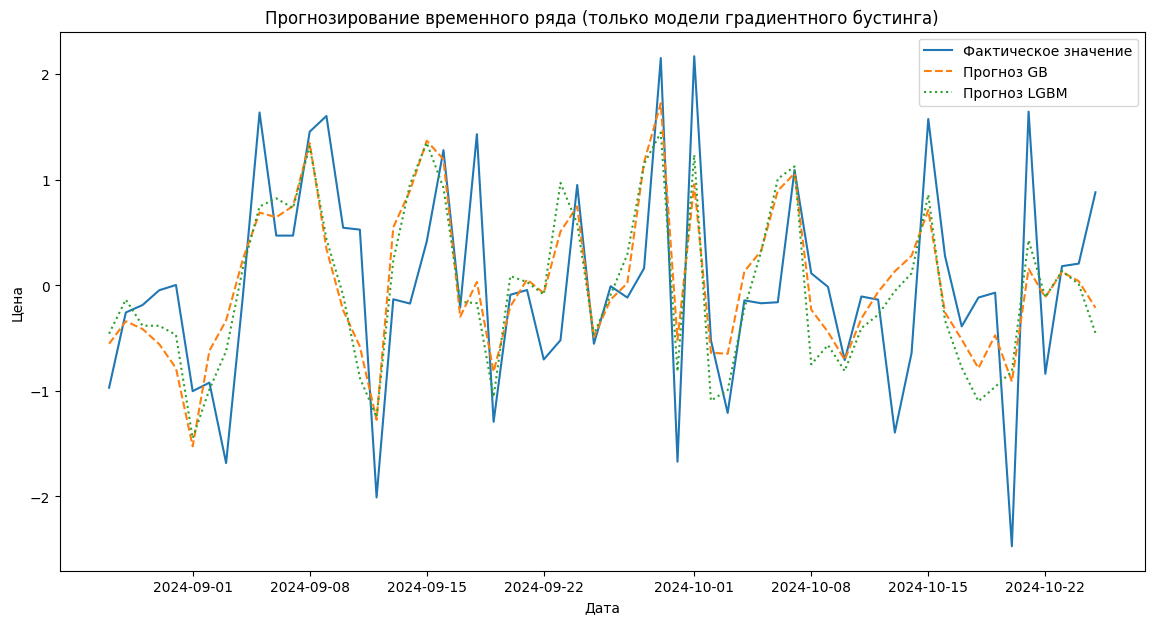

In [22]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test, label='Фактическое значение')
plt.plot(y_test.index, y_pred_xgb, label='Прогноз GB', linestyle='--')
# plt.plot(y_test.index, y_pred_cb, label='Прогноз CB', linestyle='-')
plt.plot(y_test.index, y_pred_lgbm, label='Прогноз LGBM', linestyle=':')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда (только модели градиентного бустинга)')
plt.legend()
plt.show()

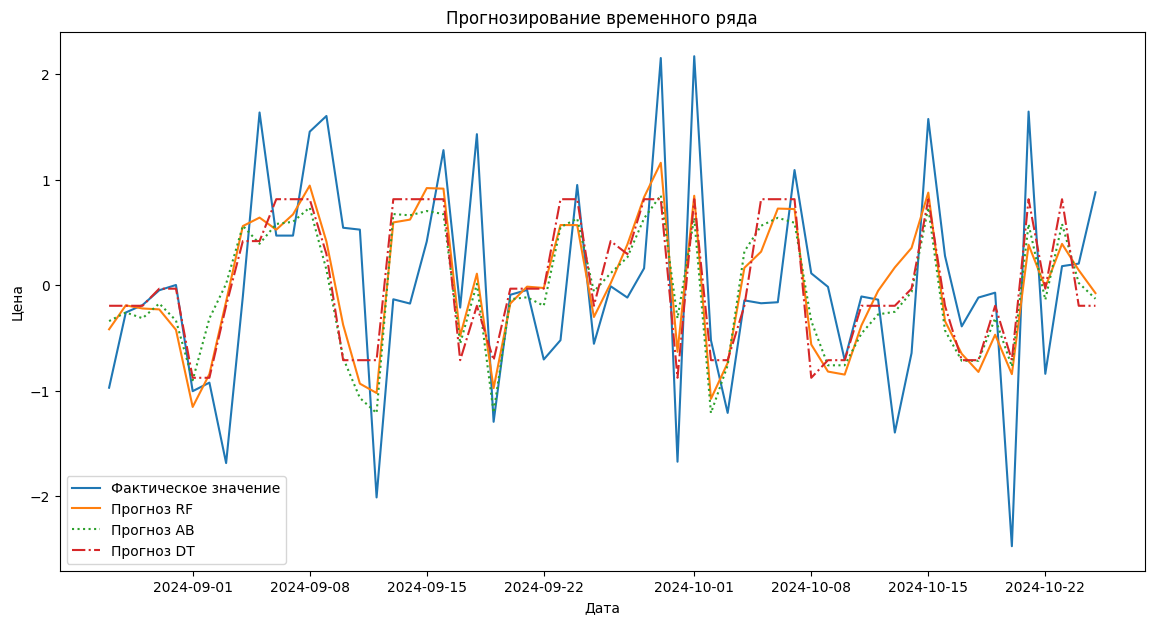

In [23]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test, label='Фактическое значение')
plt.plot(y_test.index, y_pred_rf, label='Прогноз RF', linestyle='-')
plt.plot(y_test.index, y_pred_ab, label='Прогноз AB', linestyle=':')
plt.plot(y_test.index, y_pred_dt, label='Прогноз DT', linestyle='-.')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда')
plt.legend()
plt.show()